In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tv-and-movie-metadata-with-genres-and-ratings-imbd/IMBD.csv


# **Import Libraries**

In [2]:
!pip install -q feature_engine
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings 
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import ast

pd.set_option('display.max_rows', 1000)


# **Import Datasets**

In [3]:
df = pd.read_csv("/kaggle/input/tv-and-movie-metadata-with-genres-and-ratings-imbd/IMBD.csv").drop_duplicates()
print(df.shape)
df.sample(5).T
df['stars'].head().values
df.info()
df.describe().T

(129891, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129891 entries, 0 to 129890
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movie        129891 non-null  object 
 1   genre        129891 non-null  object 
 2   runtime      109005 non-null  object 
 3   certificate  23850 non-null   object 
 4   rating       114381 non-null  float64
 5   stars        124676 non-null  object 
 6   description  129891 non-null  object 
 7   votes        114393 non-null  object 
 8   director     88611 non-null   object 
dtypes: float64(1), object(8)
memory usage: 9.9+ MB


,count,mean,std,min,25%,50%,75%,max
rating,114381.0,6.521429,1.33424,1.0,5.8,6.7,7.4,10.0


# **Transformation of Data**

In [4]:
# select main label
main_label = 'rating'
df = df[df[main_label]>0]

# vectorize columns
def vectorize_column(df, col_name, min_df=20):
    df[col_name] = df[col_name].fillna("['none']").apply(ast.literal_eval)
    df[col_name] = df[col_name].apply(lambda x: '|'.join(list(set(x))))
    ll = df[col_name].fillna('none').str.split('|').to_list()
    ll = [[j.rstrip(', ').strip(' ').replace('/', '_').replace('.', '_').replace(',', '_').replace('\'', '_').replace(' ', '_').replace('.', '_').replace('&', '_').replace('-', '_').replace('!', '_') for j in i] for i in ll]
    ll1 = []
    for item in ll:
        if item != ['none']:
            ttt = ' '.join(item)
        else:
            ttt = 'none'
        ll1.append(ttt)
    vectorizer = CountVectorizer(min_df=min_df, lowercase=False)
    vectorizer.fit(ll1)
    voc = vectorizer.vocabulary_
    voc_inv = {v: col_name+'_'+k for k, v in voc.items()}
    vector = vectorizer.transform(ll1)
    tt = pd.DataFrame(vector.toarray())
    tt = tt.rename(columns=voc_inv)
    df = pd.concat([df.reset_index(drop=True),tt.reset_index(drop=True)], axis=1).drop([col_name], axis=1)
    return df
for col in ['stars', 'director']:
    df = vectorize_column(df, col_name=col, min_df=75)
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['certificate', 'runtime', 'genre']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol=25/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
# drop unused columns
cols2drop = ['movie', 'description', 'votes']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(114381, 83)


,46482,22299,94800,14127,50307
genre,Documentary,"Documentary, Biography, History","Short, Drama",Other,"Drama, Romance"
runtime,None,114 min,20 min,87 min,115 min
certificate,None,16,None,None,A
rating,8.3,7.0,9.9,4.4,7.1
stars_Akshay_Kumar,0,0,0,0,0
stars_Al_St__John,0,0,0,0,0
stars_Alec_Baldwin,0,0,0,0,0
stars_Amitabh_Bachchan,0,0,0,0,0
stars_Anthony_Hopkins,0,0,0,0,0
stars_Antonio_Banderas,0,0,0,0,0


# **Machine learning based model**

In [5]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=350, 
                          depth=5,
                          verbose=0,
                          learning_rate=0.1, 
                          loss_function='RMSE')
# train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,3)} points, and for test {round(rmse_test,3)} points")
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,3)} points, and for test {round(rmse_bs_test,3)} points")

RMSE score for train 1.134 points, and for test 1.137 points
RMSE baseline score for train 1.341 points, and for test 1.328 points


# **SHAP Values for explanation of Model**

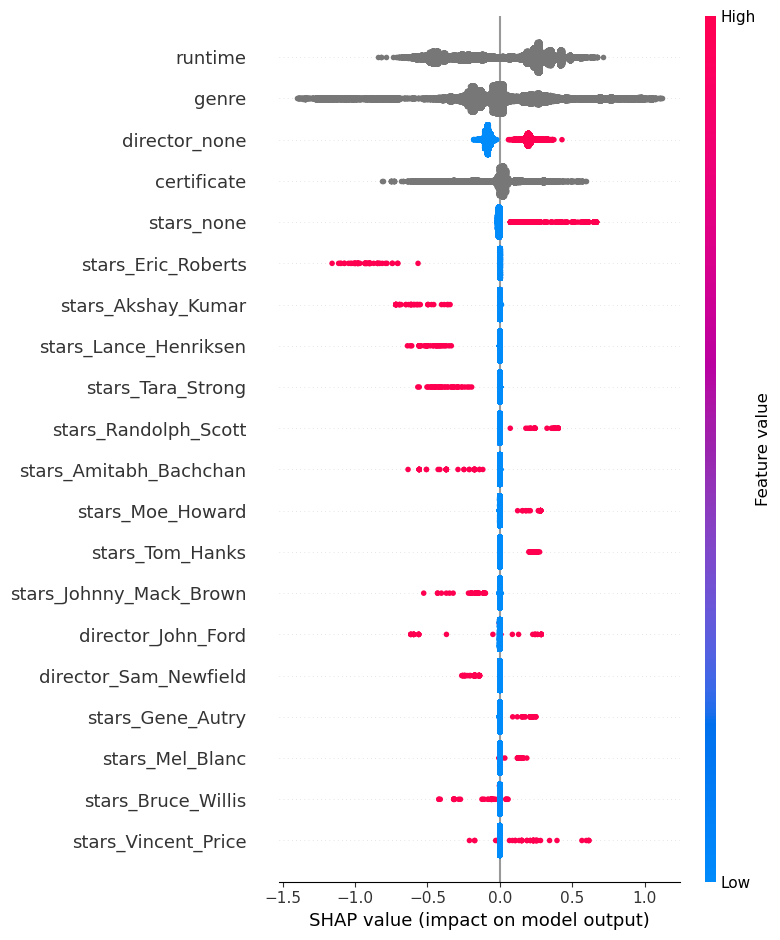

Average predicted rating is 6.512 points
Average actual rating is 6.53 points


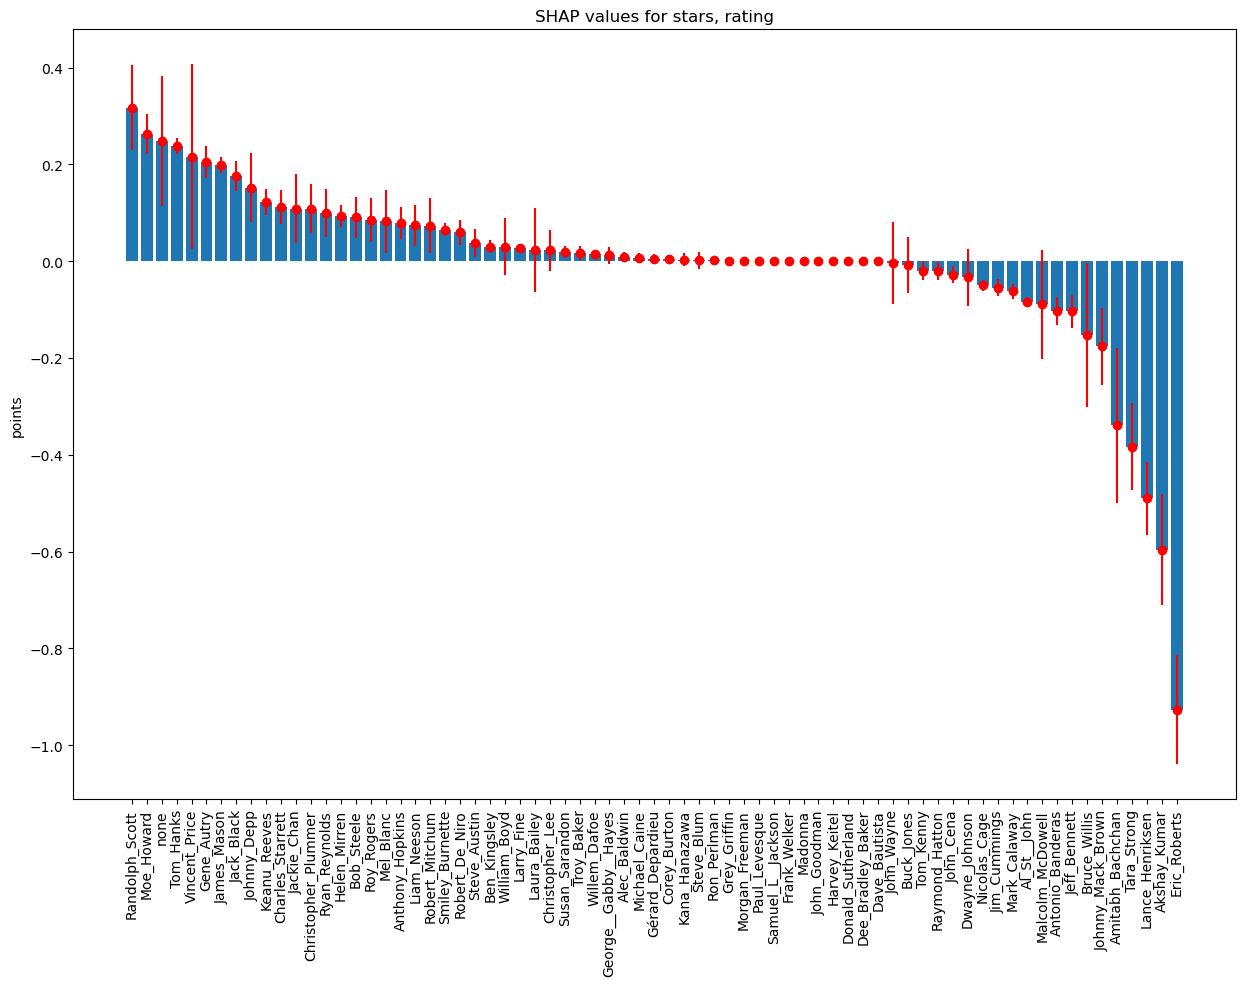

,gain,gain_std
col,,
Randolph_Scott,0.3170,0.0881
Moe_Howard,0.2633,0.0408
none,0.2491,0.1344
Tom_Hanks,0.2374,0.0164
Vincent_Price,0.2155,0.1912
Gene_Autry,0.2049,0.0322
James_Mason,0.1982,0.0164
Jack_Black,0.1759,0.0313
Johnny_Depp,0.1519,0.0712


In [6]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
expected_values = ex.expected_value
print(f"Average predicted rating is {round(expected_values,3)} points")
print(f"Average actual rating is {round(np.mean(y_test),3)} points")
def show_shap(col):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,X_test.columns.tolist().index(col)]
    gain = 0
    gain = df_infl.groupby(col).mean().loc[1, 'shap_']-df_infl.groupby(col).mean().loc[0, 'shap_']
    gain_std = ((df_infl.groupby(col).std().loc[1, 'shap_'])**2+(df_infl.groupby(col).std().loc[0, 'shap_'])**2)**0.5
    return round(gain,4), round(gain_std,4)
def show_variants(start_str):
    col_list = []
    gain_list = []
    gain_std_list = []
    for col in X_test.columns:
        if col.startswith(start_str+'_'):
            try:
                gain, gain_std = show_shap(col)
                col_list.append(col.replace(start_str+'_',''))
                gain_list.append(gain)
                gain_std_list.append(gain_std)
            except:
                pass
    dd_dict = {'col': col_list, 'gain': gain_list, 'gain_std': gain_std_list}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(15,10))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.bar(x=df_res.index, height=df_res['gain'])
    plt.title(f'SHAP values for {start_str}, rating')
    plt.ylabel('points')
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    return df_res
show_variants(start_str='stars')

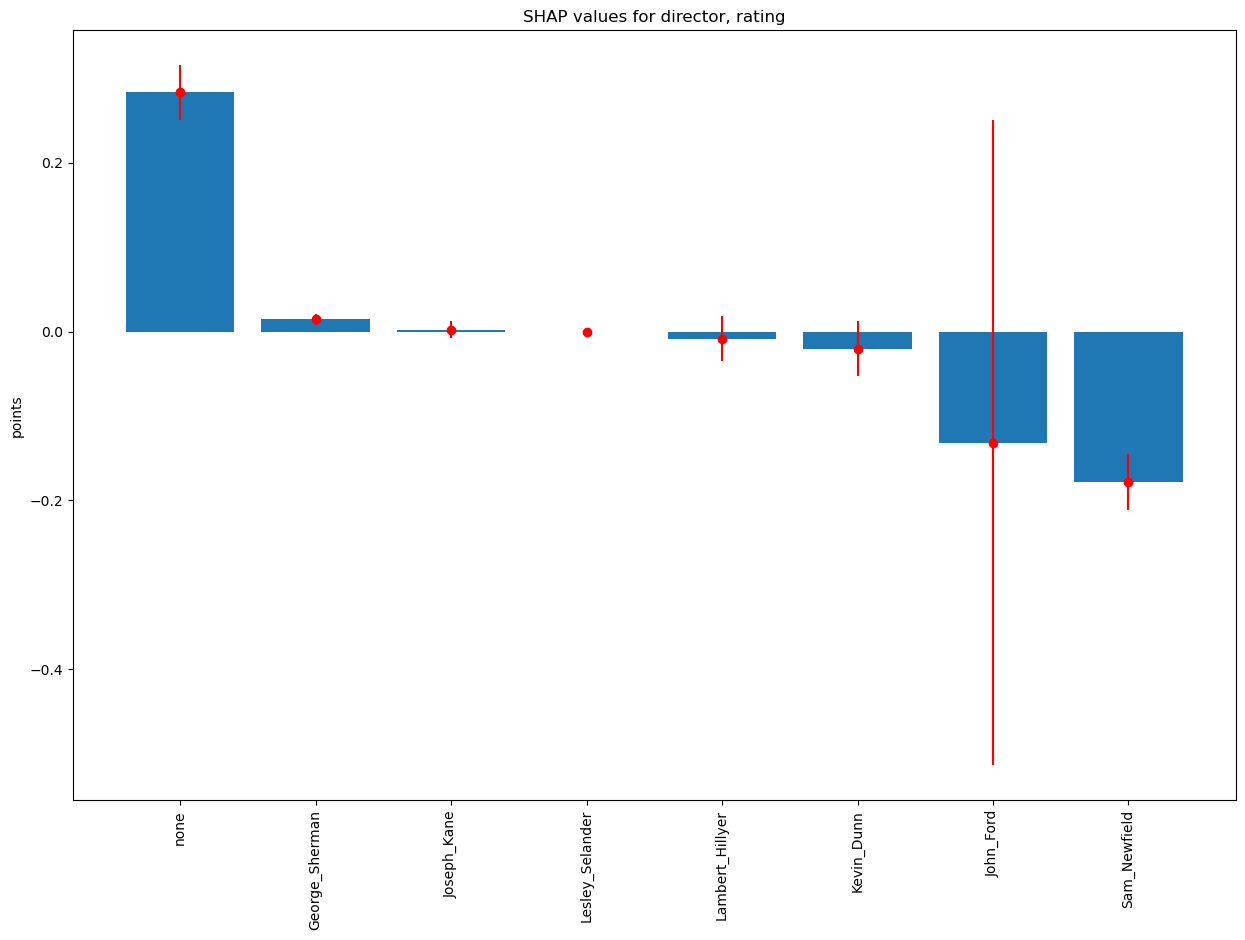

,gain,gain_std
col,,
none,0.2832,0.0322
George_Sherman,0.0146,0.0066
Joseph_Kane,0.0023,0.0101
Lesley_Selander,0.0000,0.0000
Lambert_Hillyer,-0.0084,0.0266
Kevin_Dunn,-0.0203,0.0329
John_Ford,-0.1317,0.3820
Sam_Newfield,-0.1781,0.0335


In [9]:
show_variants(start_str='director')


genre



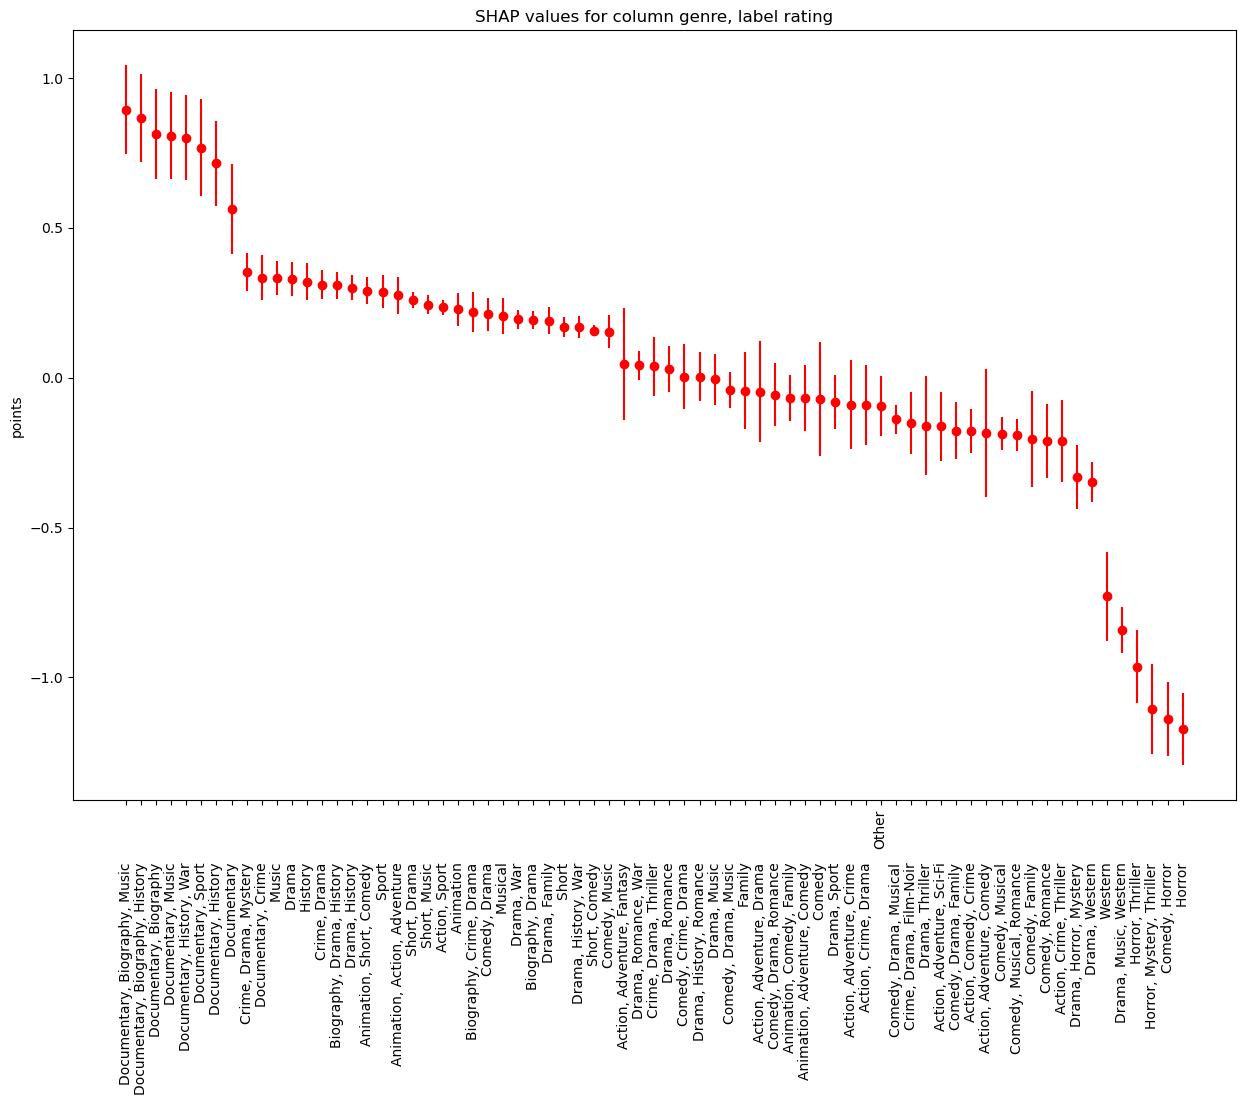

                                               gain  gain_std  count
col                                                                 
Documentary, Biography, Music                0.8951    0.1479    222
Documentary, Biography, History              0.8662    0.1477    323
Documentary, Biography                       0.8143    0.1508    562
Documentary, Music                           0.8083    0.1457    434
Documentary, History, War                    0.8005    0.1420    206
Documentary, Sport                           0.7685    0.1612    508
Documentary, History                         0.7152    0.1429    463
Documentary                                  0.5628    0.1501   2344
Crime, Drama, Mystery                        0.3527    0.0620    599
Documentary, Crime                           0.3339    0.0746    244
Music                                        0.3322    0.0571   1064
Drama                                        0.3297    0.0573    450
History                           

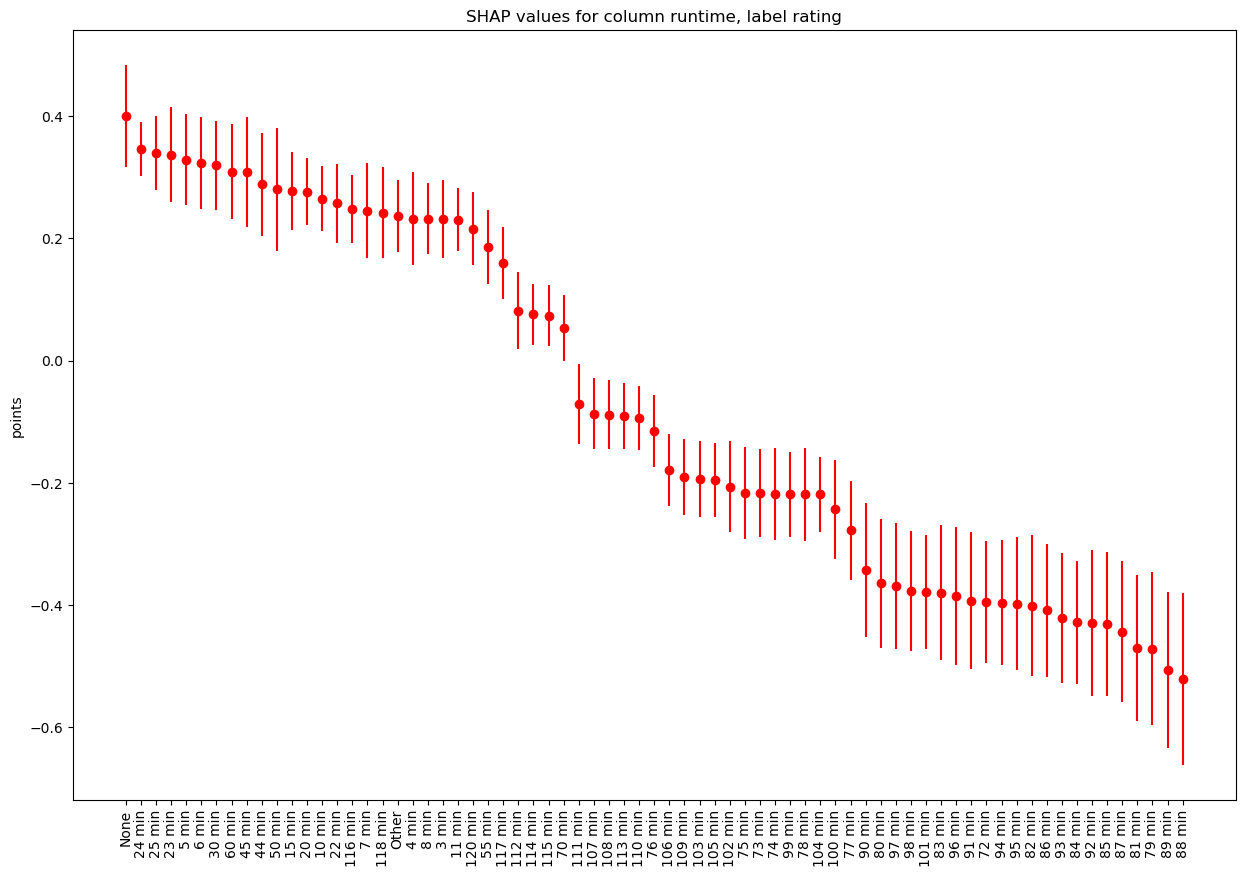

           gain  gain_std  count
col                             
None     0.4001    0.0830   6057
24 min   0.3463    0.0441    580
25 min   0.3399    0.0604    507
23 min   0.3364    0.0779    349
5 min    0.3285    0.0740    472
6 min    0.3235    0.0753    263
30 min   0.3194    0.0726   1652
60 min   0.3089    0.0780   1961
45 min   0.3076    0.0899    589
44 min   0.2885    0.0844    209
50 min   0.2800    0.1011    445
15 min   0.2769    0.0640    325
20 min   0.2764    0.0553    288
10 min   0.2648    0.0535    250
22 min   0.2571    0.0643    496
116 min  0.2476    0.0555    251
7 min    0.2453    0.0776    374
118 min  0.2415    0.0743    274
Other    0.2359    0.0591  12151
4 min    0.2323    0.0759    753
8 min    0.2322    0.0582    266
3 min    0.2316    0.0641    457
11 min   0.2303    0.0513    283
120 min  0.2158    0.0591    682
55 min   0.1858    0.0604    274
117 min  0.1591    0.0586    238
112 min  0.0815    0.0631    313
114 min  0.0759    0.0497    237
115 min  0

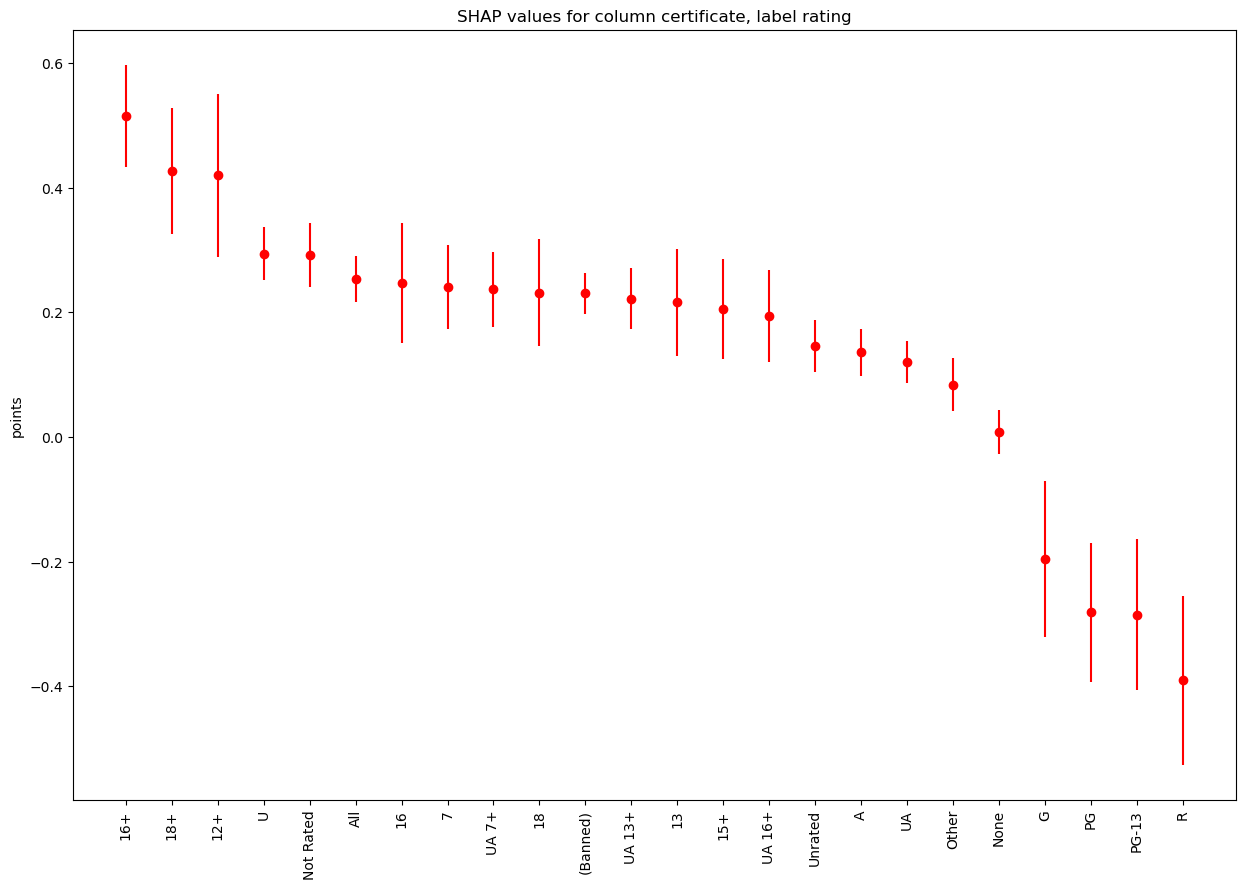

             gain  gain_std  count
col                               
16+        0.5148    0.0825     44
18+        0.4260    0.1008     26
12+        0.4196    0.1305     40
U          0.2937    0.0426   1571
Not Rated  0.2920    0.0512    285
All        0.2532    0.0365     36
16         0.2471    0.0967    371
7          0.2404    0.0680    105
UA 7+      0.2366    0.0604     58
18         0.2310    0.0859    478
(Banned)   0.2304    0.0327     19
UA 13+     0.2214    0.0490    174
13         0.2157    0.0857    223
15+        0.2055    0.0803     54
UA 16+     0.1935    0.0735    260
Unrated    0.1452    0.0419     23
A          0.1358    0.0375   1431
UA         0.1206    0.0338   1222
Other      0.0837    0.0427     60
None       0.0081    0.0349  45496
G         -0.1958    0.1247    153
PG        -0.2818    0.1119    812
PG-13     -0.2853    0.1211   1098
R         -0.3906    0.1351   3152


In [10]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='points'):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],4)
    gain_std = round(df_infl.groupby(col).std()['shap_'],4)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(15,10))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    if col.split('_')[0] not in ['stars', 'director']:
        print()
        print(col)
        print()
        show_shap(col, shap_values, label=main_label, X_test=X_test)